## Change working dir

In [1]:
import os
!cp -r /kaggle/input/pandaset-2d-images/Pandaset /kaggle/working
os.chdir('/kaggle/working/Pandaset')

## Prepare data

In [2]:
import numpy as np
import random
import shutil

In [3]:
train_images_dir = 'images'
train_maps_dir = 'semanticLabels'

In [4]:
train_images = np.array(os.listdir(train_images_dir), dtype = object)
train_maps = np.array(os.listdir(train_maps_dir), dtype = object)

print(f"There are {len(train_images)} of images")
print(f"There are {len(train_maps)} of masks")

There are 2560 of images
There are 2560 of masks


In [5]:
if os.path.exists("val_images") == False:
    os.mkdir("val_images")

if os.path.exists("val_segmaps") == False:
    os.mkdir("val_segmaps")

In [6]:
data_len = 2560
def update_train():
    global train_images, train_maps
    train_images = np.array(os.listdir(train_images_dir), dtype = object)
    train_maps = np.array(os.listdir(train_maps_dir), dtype = object)

def split_data(split_img_dir, split_map_dir, percentage = 0.2):
    n = int(data_len * percentage)
    ids = np.random.choice(train_images, n, replace = False)
    for sample in ids:
        img_fp = os.path.join(train_images_dir, sample)
        map_fp = os.path.join(train_maps_dir, sample[:-4]+'.png')
        
        os.system(f"mv {img_fp} {split_img_dir}")
        os.system(f"mv {map_fp} {split_map_dir}")

    #update training images list
    update_train()

In [7]:
val_images_dir = 'val_images'
val_maps_dir = 'val_segmaps'

# train val 75 25
split_data(val_images_dir, val_maps_dir, 0.25)

## Check preparing data

In [8]:
train_images = np.array(os.listdir(train_images_dir), dtype = object)
train_maps = np.array(os.listdir(train_maps_dir), dtype = object)

print(f"There are {len(train_images)} of images")
print(f"There are {len(train_maps)} of masks")

There are 1920 of images
There are 1920 of masks


In [9]:
val_images = np.array(os.listdir(val_images_dir), dtype = object)
val_maps = np.array(os.listdir(val_maps_dir), dtype = object)

print(f"There are {len(val_images)} of val images")
print(f"There are {len(val_maps)} of val masks")

There are 640 of val images
There are 640 of val masks


In [10]:
import cv2
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
from sklearn.preprocessing import LabelEncoder
n_classes = 13
labelencoder = LabelEncoder()

In [13]:
class Dataset:
    def __init__(self, 
               images_dir,
               maps_dir,
               augmentation = None,
               preprocessing = None):
        self.img_ids = os.listdir(images_dir) 

        self.img_fps = [os.path.join(images_dir, id ) for id in self.img_ids]
        self.map_fps = [os.path.join(maps_dir, id[:-4]+'.png' ) for id in self.img_ids]
        self.maps_dir = maps_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, idx):
        image = np.load(os.path.join(self.img_fps[idx]))
        image = image.astype(np.float32)/255

        map = Image.open(os.path.join(self.map_fps[idx]))
        map = np.array(map).astype('uint8')
        
        map = np.expand_dims(map, axis = -1)

        n, h, w = map.shape
        train_masks_reshaped = map.reshape(-1,1)
        train_masks_reshaped = np.ravel(train_masks_reshaped)
        train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
        map = train_masks_reshaped_encoded.reshape(n, h, w)
        
        map = to_categorical(map, num_classes=n_classes)
        #flip
        if np.random.rand() < 0.5:
            image = image[:, ::-1, :]
            map = map[:, ::-1, :]

        return image, map.astype(np.float32)

    def __len__(self):
        return len(self.img_ids)

In [14]:
class DataLoader(Sequence):
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.indices = np.arange(len(dataset))
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = []
        for idx in range(start, stop):
            data.append(self.dataset[idx])

        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]

        return batch

    def __len__(self):
        return len(self.indices) // self.batch_size
  
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.indices)

In [15]:
dataset = Dataset(train_images_dir, train_maps_dir)


In [16]:
BATCH_SIZE = 8
NUM_CLASSES = 13
IMG_HEIGHT=64
IMG_WIDTH=1856
IMG_CHANNELS=5

In [17]:
train_dataset = Dataset(
    train_images_dir, 
    train_maps_dir,
)

# print(sample_img.shape, sample_map.shape)
# Dataset for validation images
valid_dataset = Dataset(
    val_images_dir, 
    val_maps_dir,
)

In [18]:
# LOADING DATA
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [19]:
from keras.layers import Input, Conv2D, Concatenate, GlobalAveragePooling2D, Reshape, UpSampling2D
from keras.models import Model


def bn_relu(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dilation_rate = (1,1)):
    conv = bn_relu(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, dilation_rate = dilation_rate)(conv)
    return conv

def extract_input(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_relu(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block_with_rate(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides, dilation_rate = (1,1))
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1, dilation_rate = (1,6))

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_relu(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output


def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_relu(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c


In [20]:
def model():
    filter_factor = [8, 16, 32, 64, 128]
    inputs = keras.layers.Input((64, 1856, 5))

    ## Tiny-ResNet
    inp = inputs
    extract_inp = extract_input(inp, filter_factor[0])
    stage_1 = residual_block(extract_inp, filter_factor[0], strides=1)
    stage_2 = residual_block(stage_1, filter_factor[1], strides=2)
    stage_3 = residual_block(stage_2, filter_factor[2], strides=2)
    stage_4 = residual_block_with_rate(stage_3, filter_factor[3], strides=2)
    stage_5 = residual_block_with_rate(stage_4, filter_factor[4], strides=2)

    ## ASPP
    aspp_1 = keras.layers.Conv2D(100, kernel_size = (1,1), padding="same", strides=1)(stage_5)
    aspp_2 = keras.layers.Conv2D(100, kernel_size = (3,3), padding="same", strides=1, dilation_rate=(1, 6))(stage_5)
    aspp_3 = keras.layers.Conv2D(100, kernel_size = (3,3), padding="same", strides=1, dilation_rate=(1, 12))(stage_5)
    aspp_4 = keras.layers.Conv2D(100, kernel_size = (3,3), padding="same", strides=1, dilation_rate=(1, 18))(stage_5)
    concat = keras.layers.Concatenate()([aspp_1, aspp_2, aspp_3, aspp_4])
    aspp = keras.layers.Conv2D(128, kernel_size = (1,1), padding="same", strides=1)(concat)
    
    ## Decoder
    upsample_1 = upsample_concat_block(aspp, stage_4)
    features = residual_block(upsample_1, filter_factor[4])

    upsample_2 = upsample_concat_block(upsample_1, stage_3)
    features = residual_block(upsample_2, filter_factor[3])

    upsample_3 = upsample_concat_block(upsample_2, stage_2)
    features = residual_block(upsample_3, filter_factor[2])

    upsample_4 = upsample_concat_block(upsample_3, stage_1)
    features = residual_block(upsample_4, filter_factor[1])

    outputs = keras.layers.Conv2D(13, (1, 1), padding="same", activation="softmax")(features)
    model = keras.models.Model(inputs, outputs)
    return model

In [21]:
import keras
import tensorflow as tf


model = model()
adam = keras.optimizers.Adam(learning_rate=0.001)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            factor=0.1,
                                                            patience=5,
                                                            verbose=1,
                                                            mode='auto')

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mIoU',
    mode='max',
    save_best_only=True)

import keras.backend as K
def IoULoss(targets, inputs, smooth=1e-6):
    targets = K.flatten(targets)
    inputs = K.flatten(inputs)

    # Reshape both targets and inputs to rank-2 tensors
    targets = K.reshape(targets, (-1, 1))
    inputs = K.reshape(inputs, (-1, 1))

    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs) - intersection
    union = total + smooth

    iou = (intersection + smooth) / union
    return 1 - iou

def DiceLoss(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(targets* inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice


In [22]:
model.compile(optimizer=adam, loss=DiceLoss,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=13, name='mIoU')])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1856, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 1856, 8)  368         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 1856, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [23]:
epochs = 100
history = model.fit(train_dataloader, validation_data=valid_dataloader,
                    steps_per_epoch=len(train_dataloader),
                    validation_steps=len(valid_dataloader), epochs=epochs,
                    callbacks=[learning_rate_reduction,model_checkpoint_callback])

Epoch 1/100
240/240 [==============================] - 159s 604ms/step - loss: 0.4627 - mIoU: 0.4677 - val_loss: 0.7601 - val_mIoU: 0.4616 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 143s 595ms/step - loss: 0.3308 - mIoU: 0.4867 - val_loss: 0.4857 - val_mIoU: 0.4768 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 142s 589ms/step - loss: 0.3042 - mIoU: 0.5273 - val_loss: 0.2921 - val_mIoU: 0.5357 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 141s 586ms/step - loss: 0.2909 - mIoU: 0.5601 - val_loss: 0.2808 - val_mIoU: 0.5592 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 139s 579ms/step - loss: 0.2816 - mIoU: 0.5916 - val_loss: 0.2751 - val_mIoU: 0.6093 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 138s 573ms/step - loss: 0.2746 - mIoU: 0.6062 - val_loss: 0.2584 - val_mIoU: 0.6265 - lr: 0.0010
Epoch 7/100
240/240 [==============================] - 141s 588ms/step - loss: 0.2715 - 

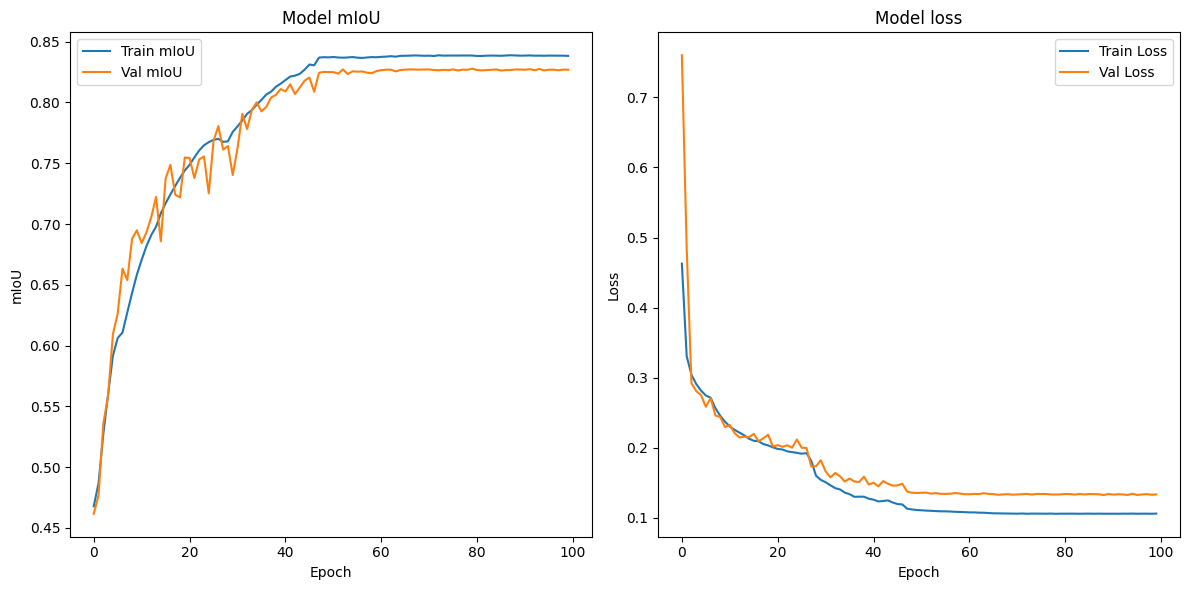

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation Mean Intersection over Union (mIoU) values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mIoU'], label='Train mIoU')
plt.plot(history.history['val_mIoU'], label='Val mIoU')
plt.title('Model mIoU')
plt.ylabel('mIoU')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
model.evaluate(test_dataloader)

640/640 [==============================] - 37s 58ms/step - loss: 0.1329 - mIoU: 0.8269


[0.13294388353824615, 0.8268569111824036]

In [26]:
from keras.models import load_model

# Lưu mô hình
model.save('ver3_700k.h5')


# # Đăng ký hàm loss tùy chỉnh 'DiceLoss'
# keras.utils.get_custom_objects().update({"DiceLoss": DiceLoss})

# model = load_model('/kaggle/input/modelver2/ver2.h5')
